<a href="https://colab.research.google.com/github/silventesa/challenge-mole/blob/francesco/Bringing_Old_Photo_Back_to_Life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#◢ Bringing Old Photos Back to Life

This is a reference implementation of our CVPR 2020 paper [1], which  revives an old photo to modern style. Should you be making use of our work, please cite our paper [1].



---


#◢ Verify Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone


In [1]:
!git clone https://github.com/microsoft/Bringing-Old-Photos-Back-to-Life.git photo_restoration

Cloning into 'photo_restoration'...
remote: Enumerating objects: 273, done.
remote: Total 273 (delta 0), reused 0 (delta 0), pack-reused 273
Receiving objects: 100% (273/273), 16.90 MiB | 44.95 MiB/s, done.
Resolving deltas: 100% (89/89), done.


#◢ Set up the environment


In [2]:
# pull the syncBN repo
%cd photo_restoration/Face_Enhancement/models/networks
!git clone https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
!cp -rf Synchronized-BatchNorm-PyTorch/sync_batchnorm .
%cd ../../../

%cd Global/detection_models
!git clone https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
!cp -rf Synchronized-BatchNorm-PyTorch/sync_batchnorm .
%cd ../../

# download the landmark detection model
%cd Face_Detection/
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
%cd ../

# download the pretrained model
%cd Face_Enhancement/
!wget https://facevc.blob.core.windows.net/zhanbo/old_photo/pretrain/Face_Enhancement/checkpoints.zip
!unzip checkpoints.zip
%cd ../

%cd Global/
!wget https://facevc.blob.core.windows.net/zhanbo/old_photo/pretrain/Global/checkpoints.zip
!unzip checkpoints.zip
%cd ../

/content/photo_restoration/Face_Enhancement/models/networks
Cloning into 'Synchronized-BatchNorm-PyTorch'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 177 (delta 8), reused 9 (delta 4), pack-reused 161
Receiving objects: 100% (177/177), 41.14 KiB | 10.28 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/photo_restoration
/content/photo_restoration/Global/detection_models
Cloning into 'Synchronized-BatchNorm-PyTorch'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 177 (delta 8), reused 9 (delta 4), pack-reused 161
Receiving objects: 100% (177/177), 41.14 KiB | 10.28 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/photo_restoration
/content/photo_restoration/Face_Detection
--2021-01-13 12:32:09--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.

In [3]:
! pip install -r requirements.txt

     |████████████████████████████████| 317kB 14.3MB/s 


#◢ Run the code

### Restore photos (normal mode)

In [4]:
%cd /content/photo_restoration/
input_folder = "test_images/old"
output_folder = "output"

import os
basepath = os.getcwd()
input_path = os.path.join(basepath, input_folder)
output_path = os.path.join(basepath, output_folder)
os.mkdir(output_path)

!python run.py --input_folder /content/photo_restoration/test_images/old --output_folder /content/photo_restoration/output/ --GPU 0

/content/photo_restoration
Running Stage 1: Overall restoration
Now you are processing a.png
Now you are processing b.png
Now you are processing c.png
Now you are processing d.png
Now you are processing e.png
Now you are processing f.png
Now you are processing g.png
Now you are processing h.png
Finish Stage 1 ...


Running Stage 2: Face Detection
1
1
1
1
Finish Stage 2 ...


Running Stage 3: Face Enhancement
The main GPU is 
0
dataset [FaceTestDataset] of size 4 was created
The size of the latent vector size is [8,8]
Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
hi :)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".fo

In [5]:
import io
import IPython.display
import numpy as np
import PIL.Image

def imshow(a, format='png', jpeg_fallback=True):
    a = np.asarray(a, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(a).save(data, format)
    im_data = data.getvalue()
    try:
      disp = IPython.display.display(IPython.display.Image(im_data))
    except IOError:
      if jpeg_fallback and format != 'jpeg':
        print(('Warning: image was too large to display in format "{}"; '
              'trying jpeg instead.').format(format))
        return imshow(a, format='jpeg')
      else:
        raise
    return disp

def make_grid(I1, I2, resize=True):
    I1 = np.asarray(I1)
    H, W = I1.shape[0], I1.shape[1]
    
    if I1.ndim >= 3:
        I2 = np.asarray(I2.resize((W,H)))
        I_combine = np.zeros((H,W*2,3))
        I_combine[:,:W,:] = I1[:,:,:3]
        I_combine[:,W:,:] = I2[:,:,:3]
    else:
        I2 = np.asarray(I2.resize((W,H)).convert('L'))
        I_combine = np.zeros((H,W*2))
        I_combine[:,:W] = I1[:,:]
        I_combine[:,W:] = I2[:,:]
    I_combine = PIL.Image.fromarray(np.uint8(I_combine))

    W_base = 600
    if resize:
      ratio = W_base / (W*2)
      H_new = int(H * ratio)
      I_combine = I_combine.resize((W_base, H_new), PIL.Image.LANCZOS)

    return I_combine

a.png


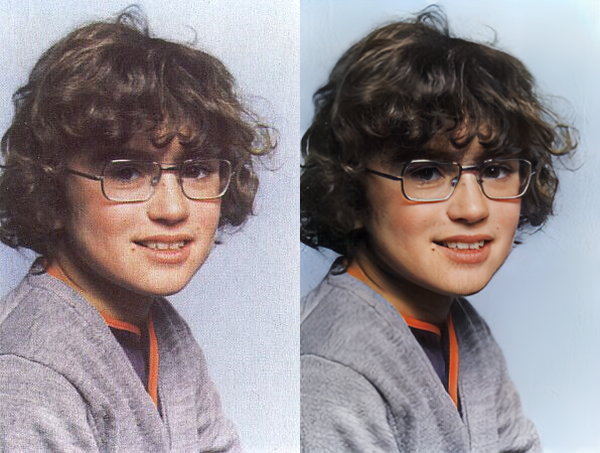

b.png


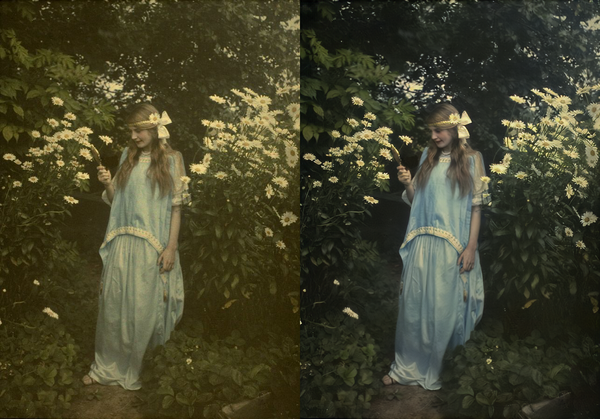

c.png


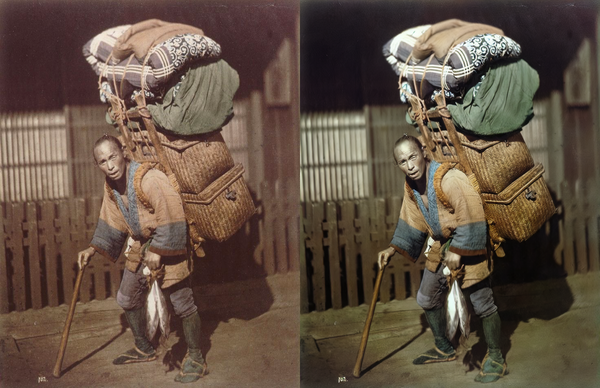

d.png


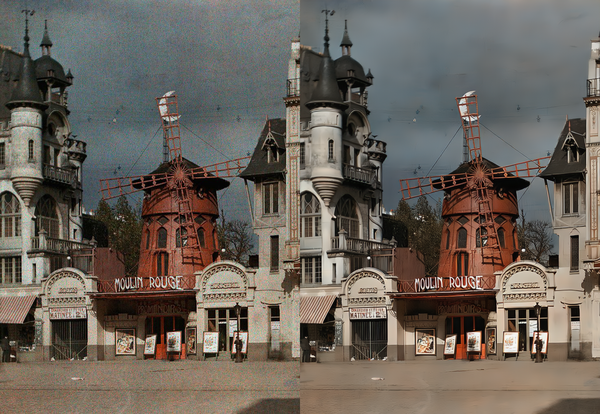

e.png


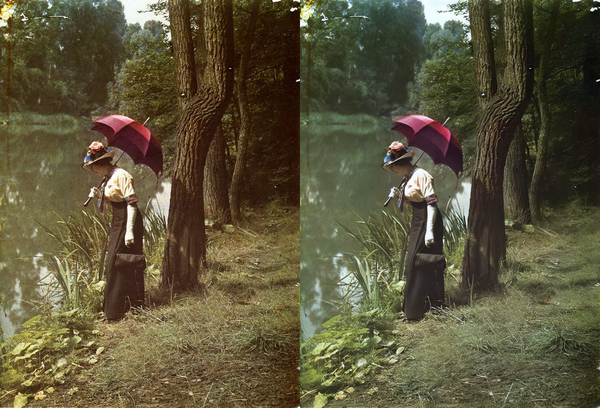

f.png


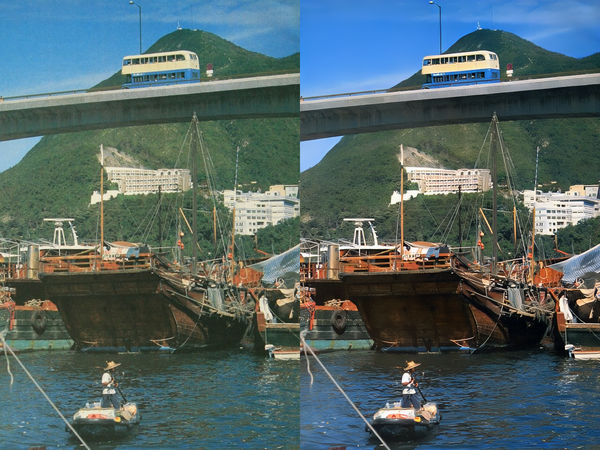

g.png


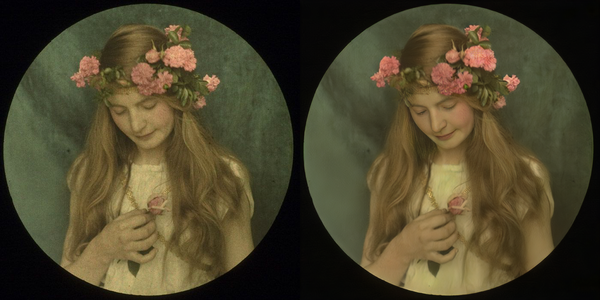

h.png


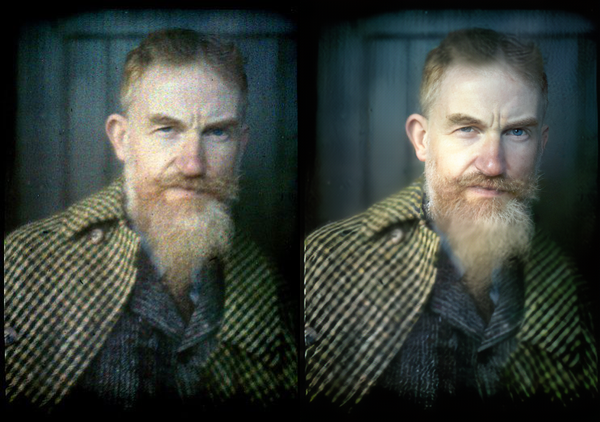

In [6]:
filenames = os.listdir(os.path.join(input_path))
filenames.sort()

for filename in filenames:
    print(filename)
    image_original = PIL.Image.open(os.path.join(input_path, filename))
    image_restore = PIL.Image.open(os.path.join(output_path, 'final_output', filename))

    display(make_grid(image_original, image_restore))

### Restore the photos with scratches

In [7]:
!rm -rf /content/photo_restoration/output/*
!python run.py --input_folder /content/photo_restoration/test_images/old_w_scratch/ --output_folder /content/photo_restoration/output/ --GPU 0 --with_scratch

Running Stage 1: Overall restoration
initializing the dataloader
model weights loaded
directory of testing image: /content/photo_restoration/test_images/old_w_scratch
processing a.png
processing b.png
processing c.png
processing d.png
You are using NL + Res
Now you are processing a.png
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Now you are processing b.png
Now you are processing c.png
Now you are processing d.png
Finish Stage 1 ...


Running Stage 2: Face Detection
1
2
1
1
Finish Stage 2 ...


Running Stage 3: Face Enhancement
The main GPU is 
0
dataset [FaceTestDataset] of size 5 was created
The size of the latent vector size is [8,8]
Network [SPADEGenerator] was created. To

a.png


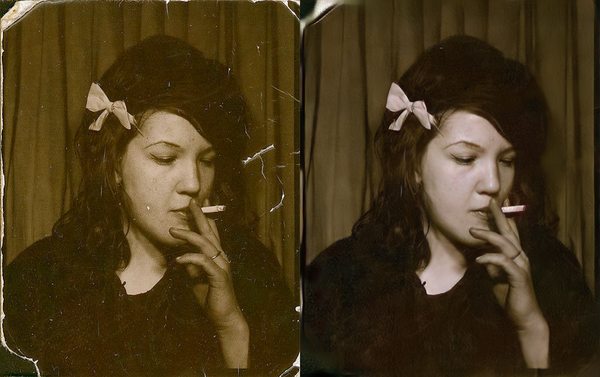

b.png


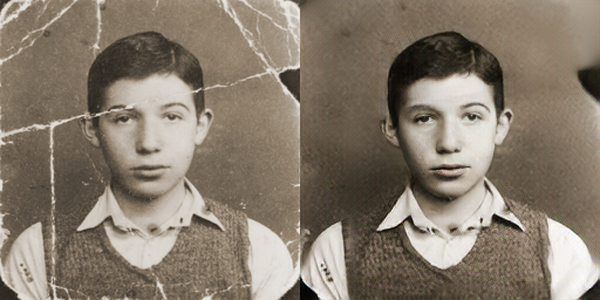

c.png


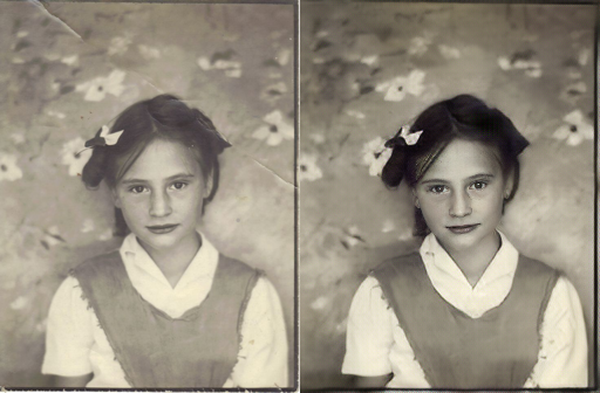

d.png


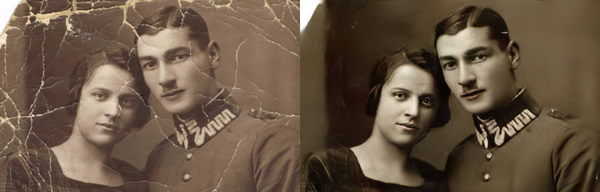

In [8]:
input_folder = "test_images/old_w_scratch"
output_folder = "output"
input_path = os.path.join(basepath, input_folder)
output_path = os.path.join(basepath, output_folder)

filenames = os.listdir(os.path.join(input_path))
filenames.sort()

for filename in filenames:
    print(filename)
    image_original = PIL.Image.open(os.path.join(input_path, filename))
    image_restore = PIL.Image.open(os.path.join(output_path, 'final_output', filename))

    display(make_grid(image_original, image_restore))

#◢ Try it on your own photos!

In [9]:
from google.colab import files
import shutil

upload_path = os.path.join(basepath, "test_images", "upload")
upload_output_path = os.path.join(basepath, "upload_output")

if os.path.isdir(upload_output_path):
    shutil.rmtree(upload_output_path)

if os.path.isdir(upload_path):
    shutil.rmtree(upload_path)

os.mkdir(upload_output_path)
os.mkdir(upload_path)

uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(os.path.join(basepath, filename), os.path.join(upload_path, filename))

Saving D1.BMP to D1.BMP


Run the processing with:

In [10]:
!python run.py --input_folder /content/photo_restoration/test_images/upload --output_folder /content/photo_restoration/upload_output --GPU 0

Running Stage 1: Overall restoration
Now you are processing D1.BMP
Finish Stage 1 ...


Running Stage 2: Face Detection
Finish Stage 2 ...


Running Stage 3: Face Enhancement
The main GPU is 
0
dataset [FaceTestDataset] of size 0 was created
The size of the latent vector size is [8,8]
Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
hi :)
Finish Stage 3 ...


Running Stage 4: Blending
Finish Stage 4 ...


All the processing is done. Please check the results.


### Visualize

Now you have all your results under the folder `upload_output` and you can *manually* right click and download them.

Here we use the child photos of celebrities from https://www.boredpanda.com/childhood-celebrities-when-they-were-young-kids/?utm_source=google&utm_medium=organic&utm_campaign=organic 

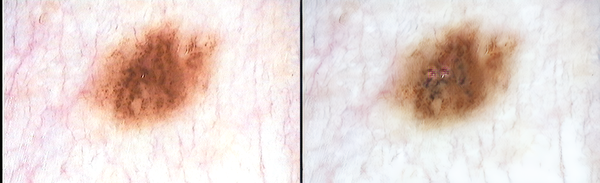

In [11]:
filenames_upload = os.listdir(os.path.join(upload_path))
filenames_upload.sort()

filenames_upload_output = os.listdir(os.path.join(upload_output_path, "final_output"))
filenames_upload_output.sort()

for filename, filename_output in zip(filenames_upload, filenames_upload_output):
    image_original = PIL.Image.open(os.path.join(upload_path, filename))
    image_restore = PIL.Image.open(os.path.join(upload_output_path, "final_output", filename_output))

    display(make_grid(image_original, image_restore))
    print("")

## Download your results



In [12]:
output_folder = os.path.join(upload_output_path, "final_output")
print(output_folder)
os.system(f"zip -r -j download.zip {output_folder}/*")
files.download("download.zip")

/content/photo_restoration/upload_output/final_output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>